# Info

3 models are tested on bands and vegedation indices data. Model training are customised to the dataset structure, please, explore it and helper functions before to start

In [ ]:
!pip3 -q install yellowbrick
!pip3 -q install imblearn
!pip3 -q install scienceplots
!pip3 -q install xgboost
!pip3 -q install seaborn

In [111]:
#libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import traceback
import os

#clustering
from shapely import affinity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from yellowbrick.cluster import KElbowVisualizer
#for PCA option
from sklearn.decomposition import PCA

#test/train split and hyperparameters optimisation
import random
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupShuffleSplit

#ML
from sklearn import preprocessing
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, classification_report, cohen_kappa_score 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

#xgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

#stats
import scipy.stats

#utils for visualisation
# import seaborn as sns
import scienceplots
import matplotlib.pyplot as plt

plt.style.use(['science', 'no-latex'])

# sns.set_style("whitegrid", {'axes.grid' : False})
# plt.rcParams.update({
#     "font.family": "serif",  
#     "font.serif": ["Times"],  
#     "font.size":9,
#     "axes.labelsize":9,
#     "xtick.labelsize" : 9,
#     "ytick.labelsize" : 9})    

dict_normal_names={7: "Pine", 
        5:"Aspen",
        1:"Birch",
        6:"Silver fir",
        15:"Burnt forest", 
        13:'Deforestation', 
        14:'Grass',
        12:'Soil', 
        16:'Swamp', 
        11:'Water body',
        17:'Settlements'}

colors =[
    '#117733',
    '#50CE57',
    '#23A28F',
    '#5BD0AE',
    '#88CCEE', 
    '#92462D', 
    '#DE7486',
    '#DDCC77',
    '#AA4499',
    '#0f62fe',
    '#be95ff'
]

#model saving
from joblib import dump, load

In [89]:
import warnings
warnings.filterwarnings('ignore')

## Helpers

In [90]:
def get_predictions_calibrated(data,
                    model,
                    param_grid,
                    target_column: str = 'class',
                    stratify_column: str = 'key',
                    to_remove_columns: list = ['key'],
                    test_size: float=0.3,
                    smote_balance: bool=True,
                    cv: int=5,
                    n_iter_search: int=15,
                    label_encoder: bool=False,
                    verbose: int = 0):
    #test/train spliting considering key overlap problems and missed classes
    while True:
        train_inds, test_inds = next(GroupShuffleSplit(test_size=test_size,
                                                   n_splits=2#,random_state = 40
                                                      ).split(data, groups=data[stratify_column]))

        train = data.iloc[train_inds]
        test = data.iloc[test_inds]
        train_classes = train[target_column].nunique()
        test_classes = test[target_column].nunique()
        all_classes = data[target_column].nunique()
        if train_classes==test_classes==all_classes:
            break
    train = train.drop(columns=to_remove_columns)
    test = test.drop(columns=to_remove_columns)
    splitter = int(len(test)/2)
    val = test.iloc[:splitter, :]
    test = test.iloc[splitter:, :]
    #class balansing with smote
    if smote_balance is True:
        smote = SMOTE(random_state = 42)
        X, y = smote.fit_resample(train.loc[:, train.columns!=target_column],
                                  train[target_column]) #drops 3 columns: key, class, and forest
        df_smote = pd.DataFrame(X, columns = train.loc[:, train.columns!=target_column].columns.tolist()) #drops 3 columns: key, class, and forest
        X_train = df_smote
        y_train = y
        X_test = test.loc[:, train.columns!=target_column]
        y_test = test[target_column]

    else:
        X_train = train.loc[:, train.columns!=target_column]
        y_train = train[target_column]
        X_test = test.loc[:, test.columns!=target_column]
        y_test = test[target_column]
        X_val = val.loc[:, val.columns!=target_column]
        y_val = val[target_column]

    #parameters optimisation

    gs = RandomizedSearchCV(model,
                            param_distributions = param_grid,
                            n_iter = n_iter_search,
                            cv = cv,
                            scoring= 'f1_weighted', 
                            verbose=verbose,
                           n_jobs = 10)

    if label_encoder == True:
        print('label_encoder == True')
        le = LabelEncoder()
        gs.fit(X_train, le.fit_transform(y_train))
        y_pred = gs.best_estimator_.predict(X_test.values)
        model_fit = gs.best_estimator_
        model_calibrated = CalibratedClassifierCV(estimator=model_fit, cv='prefit', method='sigmoid')
        model_calibrated.fit(X_val.values, y_val.values)

        results = {'model': model_calibrated,
            'X_train data': X_train,
            'y train data': y_train,
            'X test data': X_test,
            'y test data': y_test,
            'y predicted': le.inverse_transform(y_pred)
            }

    else:
        gs.fit(X_train, y_train)
        y_pred = gs.best_estimator_.predict(X_test.values)
        model_fit = gs.best_estimator_
        model_calibrated = CalibratedClassifierCV(estimator=model_fit, cv='prefit', method='sigmoid')
        model_calibrated.fit(X_val.values, y_val.values)




        results = {'model': model_calibrated,
                   'X_train data': X_train,
                   'y train data':  y_train,
                   'X test data': X_test,
                   'y test data': y_test,
                   'y predicted': y_pred

        }

    return results

In [91]:
def metrics_description(y_true, y_pred, 
                        metrics_by_class: bool=True, 
                        confusion_matrix_multiclass_on: bool=True,
                        binary_matrix_on: bool=False):

    
    print('Accuracy score: %.2f%%' %(accuracy_score(y_true, y_pred)*100))  
    print('Precision score: %.2f%%' % (precision_score(y_true, y_pred, average= 'weighted')*100))
    print('Recall score: %.2f%%' % (recall_score(y_true, y_pred, average= 'weighted')*100))
    print('F1-Score: %.2f%%'%(f1_score(y_true, y_pred, average = 'weighted')*100))
    print('Kappa score: %.2f%%'%(cohen_kappa_score(y_true, y_pred)*100))
    
    
    #dataframe with metrics by class
    if metrics_by_class is True:
        metrics_by_class = pd.DataFrame(
                {
                    'names': list(map(dict_normal_names.get, list(np.unique(y_true)))),
                    'f1_scores': f1_score(y_true, y_pred,
                               average=None).round(2).tolist(),
                    'precision': precision_score(y_true, y_pred, 
                                       average=None).round(2).tolist(),
                    'recall':recall_score(y_true, y_pred,
                                       average=None).round(2).tolist()
                }
            )
        display(metrics_by_class)

    #confusion matrix multiclass
    if confusion_matrix_multiclass_on is True:
        data = confusion_matrix(y_true, y_pred)
        df_cm = pd.DataFrame(data, columns=list(map(dict_normal_names.get, list(np.unique(y_true)))), 
                             index = list(map(dict_normal_names.get, list(np.unique(y_true)))))
        df_cm.index.name = 'Actual'
        df_cm.columns.name = 'Predicted'

        #confusion matrix plot
        f, ax = plt.subplots(figsize=(6, 10))
        cmap = sns.cubehelix_palette(light=1, as_cmap=True)

        sns.heatmap(df_cm, cbar=False, annot=True, cmap=cmap, square=True, fmt='.0f',
                    annot_kws={'size': 10})
        plt.title('Actuals vs Predicted')
        plt.show()
        
    #confusion matrix binary    
    if binary_matrix_on is True:
        cm = confusion_matrix(y_true, y_pred)
        print('Confusion matrix\n\n', cm)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [92]:
#getting dataset with metrics by class for each random prediction
def get_classes_metrics(models_vector): #vector with model variations, y predicted and y true from the dataset
    class_metrics_dataframe = pd.DataFrame()
    count = 0 #counter of iteration

    for i in models_vector:

        count += 1 #counting
        pred = i['y predicted'] #predicted values 
        true = i['y test data'] #corresponding labels from random test set
        names_list = list(np.unique(true))

        temp = pd.DataFrame(
            {
                'iteration':[count]*len(names_list), 
                'names': list(map(dict_normal_names.get, names_list)),
                'f1_scores': f1_score(true, pred,
                           average=None).round(2).tolist(),
                'precision_list': precision_score(true, 
                                   pred, 
                                   average=None).round(2).tolist(),
                'recall':recall_score(true, 
                                   pred, 
                                   average=None).round(2).tolist()
            }
        ) #dataset for each model 

        class_metrics_dataframe = pd.concat([class_metrics_dataframe, temp], ignore_index=True)
    return class_metrics_dataframe 

In [93]:
#getting dataset with average metrics for each random prediction
def get_metrics_average(models_vector): #vector with model variations, y predicted and y true from the dataset
    average_metrics_dataframe = pd.DataFrame()
    count = 0 #counter of iteration

    for i in models_vector:

        count += 1 #counting
        pred = i['y predicted'] #predicted values 
        true = i['y test data'] #corresponding labels from random test set

        temp = pd.DataFrame(
            {
                'iteration':[count],#*len(names_list), 
                #'names': list(map(dict_normal_names.get, names_list)),
                'f1_scores': f1_score(true, pred,
                           average='macro').round(2).tolist(),
                'precision': precision_score(true, 
                                   pred, 
                                   average='weighted').round(2).tolist(),
                'recall':recall_score(true, 
                                   pred, 
                                   average='weighted').round(2).tolist()
            }
        ) #dataset for each model 

        average_metrics_dataframe = pd.concat([average_metrics_dataframe, temp], 
                                              ignore_index=True)
    return average_metrics_dataframe 

In [94]:
def get_best_model(datavector_models):
    number = get_metrics_average(datavector_models).sort_values(by='f1_scores', 
                                                                ascending=False).head(1).reset_index()['index'].values[0]
    best_model = datavector_models[number]['model']
    return best_model

In [95]:
def get_worst_model(datavector_models):
    number = get_metrics_average(datavector_svc_wf).sort_values(by='f1_scores', 
                                                                ascending=False).tail(1).reset_index()['index'].values[0]
    best_model = datavector_models[number]['model']
    return best_model

# Data preparation

In [96]:
def get_scaled_data(path:str, cols_remove:list=['key', 'class']):
    df = pd.read_csv(path, index_col=0)
    x = df.drop(columns=cols_remove).values
    #minmax scaling
    min_max_scaler = preprocessing.MinMaxScaler() 
    x_scaled = min_max_scaler.fit_transform(x)
    target_cols = [col for col in list(df.columns) if col not in cols_remove]
    df.loc[:, target_cols] = x_scaled
    return df, min_max_scaler
folder = '../shape_data/filtered_datasets/'
df_scaled, min_max_scaler = get_scaled_data(os.path.join(folder, 'df1.csv'))

In [97]:
#for random forest
from sklearn.calibration import CalibratedClassifierCV
# Number of trees in random forest
def get_random_forest():
    n_estimators = np.arange(100,300,10)
    max_depth = np.arange(10,110,11)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    random_grid = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}
    return {'model': RandomForestClassifier(bootstrap=True, n_jobs=-1),
           "grid":random_grid}


def get_svm():
    svc_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'poly']
             }
    return {'model': SVC(probability=True),
           "grid":svc_grid}


def get_KNN():
    metric = ['euclidean','manhattan','chebyshev','minkowski']
    n_neighbors = np.arange(4,15,2)
    weights = ['uniform','distance']
    random_grid_knn = {'n_neighbors': n_neighbors,
        'weights': weights,
        'metric': metric}
    return {'model': KNeighborsClassifier(),
           "grid":random_grid_knn}

def get_XGB():
    params = { 'max_depth': [3,6,10],
           "min_child_weight": [0.5, 1, 2],
           'n_estimators': np.arange(10,100,20),
           'colsample_bytree': [0.3, 0.7, 1]}
    return {"model": xgb.XGBClassifier(n_jobs=8),
           "grid":params}



## Model training

## 🚨 --  n_jobs добавить в Grid Search CV

--- 

Обновить кодировку классов 

In [114]:
gdf = gpd.read_file('../shape_data/dataset_plots.geojson')

In [134]:
def get_gdf_dataset(
    gdf: gpd.GeoDataFrame, non_forest: gpd.GeoDataFrame, threshold: float = 80
):
    rename = {
        "SOS_PRC": "С",
        "OS_PRC": "ОС",
        "BER_PRC": "Б",
        "PICH_PRC": "П",
        "EL_PRC": "Е",
        "KEDR_PRC": "К",
        "LSTV_PRC": "Л",
    }

    code_class = {"С": 7, "ОС": 5, "Б": 1, "П": 6, "Е": 2, "К": 3, "Л": 4}

    target_cols = [
        "EL_PRC",
        "KEDR_PRC",
        "LSTV_PRC",
        "PICH_PRC",
        "SOS_PRC",
        "BER_PRC",
        "OS_PRC",
    ]

    mask = gdf[target_cols] > threshold
    select = gdf.loc[mask.any(axis=1)].copy()
    t = select.loc[:, target_cols].idxmax(axis=1)
    select.loc[:, "t"] = select.loc[:, target_cols].idxmax(axis=1)
    select.loc[:, "t_Клас"] = select["t"].apply(lambda x: rename[x])
    select.loc[:, "t_Class"] = select["t_Клас"].apply(lambda x: code_class[x])
    select.pop("t")
    non_forest[select.columns[:-3]] = 1
    select = pd.concat([select, non_forest[select.columns]])
    return select


In [155]:
full_dataset = "../shape_data/forest.geojson"
gdf = gpd.read_file(full_dataset)
non_forest=gpd.read_file('../shape_data/non_forest_settlements.geojson')

# threshold=80 -> Percent of main forest type for inventory plot
gdf = get_gdf_dataset(gdf=gdf, non_forest=non_forest,  threshold=75)
gdf = gdf.reset_index(drop=True)
gdf.loc[:, 'key'] = gdf.index


In [156]:
gdf.groupby('t_Клас').count()

,Plot_ID,xc,yc,Plot_ID_1,HDOM_check,HGW_check,HGW,HGW11,HGW12,HGW13,...,KEDR_PRC,LSTV_PRC,PICH_PRC,SOS_PRC,BER_PRC,OS_PRC,V_PRC_ALL,geometry,t_Class,key
t_Клас,,,,,,,,,,,,,,,,,,,,,
Б,38,38,38,38,38,38,38,38,38,38,...,38,38,38,38,38,38,38,38,38,38
Е,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Л,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
ОС,66,66,66,66,66,66,66,66,66,66,...,66,66,66,66,66,66,66,66,66,66
П,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
С,83,83,83,83,83,83,83,83,83,83,...,83,83,83,83,83,83,83,83,83,83
болото,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
вырубки,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
гарь,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [148]:
gdf_full = gpd.read_file('../shape_data/dataset_plots.geojson')

In [152]:
gdf_full.loc[gdf_full['t_Class']<10].groupby(['t_Клас']).count()

,Plot_ID,t_С,t_Л,t_Б,t_ОС,t_Е,t_П,t_К,t_Class,geometry
t_Клас,,,,,,,,,,
Б,54,54,54,54,54,54,54,54,54,54
Е,14,14,14,14,14,14,14,14,14,14
К,6,6,6,6,6,6,6,6,6,6
Л,21,21,21,21,21,21,21,21,21,21
ОС,62,62,62,62,62,62,62,62,62,62
П,24,24,24,24,24,24,24,24,24,24
С,42,42,42,42,42,42,42,42,42,42


In [ ]:
folder = '../shape_data/filtered_datasets'
datasets = os.listdir(folder)

metric_container = None
problems = []
for dataset in sorted(datasets):
    scale = dataset[2]
    is_filtered = True if '_' in dataset else False
    df_scaled, min_max_scaler = get_scaled_data(os.path.join(folder, dataset))    
    mask_forest = df_scaled['class']<10
    df_forest = df_scaled.loc[mask_forest]
    models = {'RandomForest': get_random_forest(), 
             "SVC":get_svm(),
             "kNN":get_KNN(),
             "XGB":get_XGB()}
    for model, settings in models.items():
        datavector = []
        for i in range(15):
            print(f"{dataset} ---- {model} ---- {i}")
            try:
                trained_model = get_predictions_calibrated(data = df_forest,
                            model = settings['model'],
                            param_grid = settings['grid'],
                            target_column = 'class',
                            to_remove_columns=['key'],
                            smote_balance=False,
                            cv=5, 
                            n_iter_search=20, 
                            label_encoder=True if model == 'XGB' else False, )
                datavector.append(trained_model)
                status = 'Done'
            except Exception as e:
                traceback.print_exc()
                problem = {}
                problem['fname'] = dataset
                problem['model'] = model
                problem['scale'] = scale
                status = 'Error'
                problems.append(problem)
                print(status)
                continue
        model_metrics = get_classes_metrics(datavector)
        model_metrics['model'] = model
        model_metrics['scale'] = scale
        model_metrics['is_filtered'] = is_filtered
        model_metrics['fname'] = dataset
        model_metrics['experiment_status'] = dataset
        if metric_container is None:
            metric_container = model_metrics
        else: 
            metric_container = pd.concat([metric_container, model_metrics], axis=0)
        best_model = get_best_model(datavector)
        core = dataset.split('.')[0]
        model_path = os.path.join(f'../models/calibrated_models/{model}_{core}.joblib')
        dump(best_model, model_path)
    metric_container.to_csv('../shape_data/metric_results_UQ.csv')


df1.csv ---- RandomForest ---- 0
df1.csv ---- RandomForest ---- 1
df1.csv ---- RandomForest ---- 2
df1.csv ---- RandomForest ---- 3
df1.csv ---- RandomForest ---- 4


## TO-DO

>After modifying it as below, it will run without error.
knn1.predict(X.values)

https://github.com/scikit-learn/scikit-learn/issues/26768

In [12]:
# mask_forest = df_scaled['class']<10

In [95]:
metric_container.to_csv('../shape_data/metric_results.csv')
metric_container

,iteration,names,f1_scores,precision_list,recall,model,scale,is_filtered,fname
0,1,Birch,0.34,0.37,0.31,RandomForest,1,False,df1.csv
1,1,Aspen,0.64,0.60,0.68,RandomForest,1,False,df1.csv
2,1,Silver fir,0.71,1.00,0.55,RandomForest,1,False,df1.csv
3,1,Pine,0.78,0.76,0.79,RandomForest,1,False,df1.csv
4,2,Birch,0.36,0.43,0.31,RandomForest,1,False,df1.csv
...,...,...,...,...,...,...,...,...,...
15,4,Pine,0.75,0.72,0.78,SVC,1,True,df1_filtered_all.csv
16,5,Birch,0.00,0.00,0.00,SVC,1,True,df1_filtered_all.csv
17,5,Aspen,0.50,0.40,0.65,SVC,1,True,df1_filtered_all.csv
18,5,Silver fir,0.24,1.00,0.13,SVC,1,True,df1_filtered_all.csv


In [105]:
folder = '../shape_data/filtered_datasets'
datasets = os.listdir(folder)

metric_container = None
problems = []
dataset = sorted(datasets)[0]
scale = dataset[2]
is_filtered = True if '_' in dataset else False
df_scaled, min_max_scaler = get_scaled_data(os.path.join(folder, dataset))    
mask_forest = df_scaled['class']<10
df_forest = df_scaled.loc[mask_forest]
models = {'RandomForest': get_random_forest(), 
         "SVC":get_svm(),
         "kNN":get_KNN(),
         "XGB":get_XGB()}


for model, settings in models.items():
    if model!='kNN':
        continue
    datavector = []
    for i in range(1):
        trained_model = get_predictions_calibrated(data = df_forest,
                                model = settings['model'],
                                param_grid = settings['grid'],
                                target_column = 'class',
                                to_remove_columns=['key'],
                                smote_balance=False,
                                cv=5, 
                                n_iter_search=1,
                                verbose=2, 
                                label_encoder=True if model == 'XGB' else False, )
        datavector.append(trained_model)
    print(model)
    model_clf = trained_model['model']

    print(model_clf.predict_proba(trained_model['X test data']))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
kNN


AttributeError: 'Flags' object has no attribute 'c_contiguous'

In [108]:
datavector

[{'model': CalibratedClassifierCV(cv='prefit',
                         estimator=KNeighborsClassifier(metric='euclidean',
                                                        n_neighbors=8)),
  'X_train data':          B01       B02       B03       B04       B05       B06       B07  \
  0   0.207061  0.063533  0.102060  0.067632  0.241176  0.529808  0.617605   
  1   0.207061  0.066374  0.105103  0.065687  0.241176  0.529808  0.617605   
  2   0.225191  0.067149  0.105571  0.068064  0.245882  0.535192  0.628427   
  3   0.207061  0.069473  0.104635  0.067848  0.249706  0.524423  0.612013   
  4   0.207061  0.066890  0.105571  0.069576  0.249706  0.524423  0.612013   
  ..       ...       ...       ...       ...       ...       ...       ...   
  4   0.259542  0.069215  0.117041  0.109334  0.328824  0.807692  0.979076   
  5   0.259542  0.066116  0.110019  0.105877  0.321176  0.806923  0.979076   
  6   0.259542  0.063533  0.112828  0.105445  0.336471  0.812692  0.965368   
  7   0.

In [109]:
get_classes_metrics(datavector)

,iteration,names,f1_scores,precision_list,recall
0,1,Birch,0.39,0.41,0.37
1,1,Aspen,0.60,0.59,0.61
2,1,Silver fir,0.36,0.50,0.29
3,1,Pine,0.76,0.74,0.77


In [76]:
from sklearn.calibration import CalibratedClassifierCV
folder = '../shape_data/filtered_datasets'
datasets = os.listdir(folder)

metric_container = None
problems = []
dataset = sorted(datasets)[0]
print(dataset)
scale = dataset[2]
is_filtered = True if '_' in dataset else False
df_scaled, min_max_scaler = get_scaled_data(os.path.join(folder, dataset))    
mask_forest = df_scaled['class']<10
df_forest = df_scaled.loc[mask_forest]


data = df_forest
settings = models['RandomForest']
model = settings['model']
param_grid = settings['grid']
target_column = 'class'
to_remove_columns=['key']
stratify_column = 'key'
smote_balance=False
cv=5
n_iter_search=1
verbose=2
label_encoder=True if model == 'XGB' else False
test_size=0.4
while True:
    train_inds, test_inds = next(GroupShuffleSplit(test_size=test_size,
                                               n_splits=2#,random_state = 40
                                                  ).split(data, groups=data[stratify_column]))

    train = data.iloc[train_inds]
    test = data.iloc[test_inds]
    splitter = int(len(test)/2)
    val = test.iloc[:splitter, :]
    test = test.iloc[splitter:, :]

    train_classes = train[target_column].nunique()
    test_classes = test[target_column].nunique()
    all_classes = data[target_column].nunique()
    val_classes = val[target_column].nunique()
    if train_classes==test_classes==all_classes==val_classes:
        break
train = train.drop(columns=to_remove_columns)
test = test.drop(columns=to_remove_columns)
val = val.drop(columns=to_remove_columns)
#class balansing with smote
if smote_balance is True:
    smote = SMOTE(random_state = 42)
    X, y = smote.fit_resample(train.loc[:, train.columns!=target_column],
                              train[target_column]) #drops 3 columns: key, class, and forest
    df_smote = pd.DataFrame(X, columns = train.loc[:, train.columns!=target_column].columns.tolist()) #drops 3 columns: key, class, and forest
    X_train = df_smote
    y_train = y
    X_test = test.loc[:, train.columns!=target_column]
    y_test = test[target_column]

else:
    X_train = train.loc[:, train.columns!=target_column]
    y_train = train[target_column]
    X_test = test.loc[:, test.columns!=target_column]
    y_test = test[target_column]
    X_val = val.loc[:, val.columns!=target_column]
    y_val = val[target_column]

#parameters optimisation

gs = RandomizedSearchCV(model,
                        param_distributions = param_grid,
                        n_iter = n_iter_search,
                        cv = cv,
                        scoring= 'f1_weighted', 
                        verbose=verbose,
                       n_jobs = 10)

if label_encoder == True:
    print('label_encoder == True')
    le = LabelEncoder()
    gs.fit(X_train, le.fit_transform(y_train))
    y_pred = gs.best_estimator_.predict(X_test.values)
    model_fit = gs.best_estimator_
    model_calibrated = CalibratedClassifierCV(estimator=model_fit, cv='prefit', method='sigmoid')
    model_calibrated.fit(X_val, y_val)
    
    results = {'model': model_calibrated,
        'X_train data': X_train,
        'y train data': y_train,
        'X test data': X_test,
        'y test data': y_test,
        'y predicted': le.inverse_transform(y_pred)
        }

else:
    gs.fit(X_train, y_train)
    y_pred = gs.best_estimator_.predict(X_test.values)
    model_fit = gs.best_estimator_
    model_calibrated = CalibratedClassifierCV(estimator=model_fit,
                                              cv='prefit', 
                                              method='sigmoid')
    model_calibrated.fit(X_val, y_val)
    



    results = {'model': model_calibrated,
               'X_train data': X_train,
               'y train data':  y_train,
               'X test data': X_test,
               'y test data': y_test,
               'y predicted': y_pred

    }

# return results

df1.csv
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [73]:
import seaborn as sns

In [74]:
sns.set_context('talk')

In [85]:
print(classification_report(y_test, model_calibrated.predict(X_test)))

              precision    recall  f1-score   support

           1       0.60      0.27      0.37       107
           5       0.40      0.63      0.49        89
           6       1.00      0.83      0.91        24
           7       0.75      0.82      0.79       130

    accuracy                           0.61       350
   macro avg       0.69      0.64      0.64       350
weighted avg       0.63      0.61      0.59       350



In [84]:
print(classification_report(y_test, model_fit.predict(X_test)))

              precision    recall  f1-score   support

           1       0.58      0.33      0.42       107
           5       0.41      0.63      0.50        89
           6       0.82      0.96      0.88        24
           7       0.79      0.76      0.78       130

    accuracy                           0.61       350
   macro avg       0.65      0.67      0.64       350
weighted avg       0.63      0.61      0.60       350



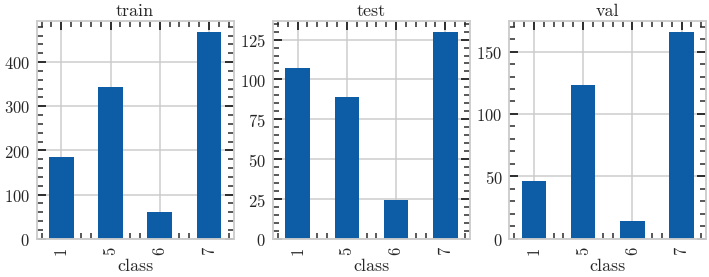

In [77]:
fig, axes = plt.subplots(1,3, figsize=(12,4))
axes = axes.flatten()
plotting = {'train':train, 'test': test, 'val': val}
for i, ax in enumerate(axes):
    plotting[list(plotting.keys())[i]].groupby('class')['B03'].count().plot(kind='bar', ax=ax)
    ax.set_title(list(plotting.keys())[i])


In [59]:
val.groupby('class').count()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,...,contrast1,contrast2,correlation1,correlation2,dissimilarity1,dissimilarity2,energy1,energy2,homogeneity1,homogeneity2
class,,,,,,,,,,,,,,,,,,,,,
1,32,32,32,32,32,32,32,32,32,32,...,32,32,32,32,32,32,32,32,32,32
5,84,84,84,84,84,84,84,84,84,84,...,84,84,84,84,84,84,84,84,84,84
7,149,149,149,149,149,149,149,149,149,149,...,149,149,149,149,149,149,149,149,149,149


In [57]:
val['NDVI'].groupby('class').count().plot(kind='bar')

KeyError: 'class'

<AxesSubplot:xlabel='class'>

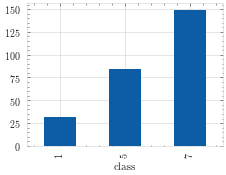

In [56]:
val.groupby('class')['NDVI'].count().plot(kind='bar')

In [26]:
train_inds.shape

(1063,)

In [30]:
trained_model['y predicted']

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 0, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1,
       1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,

In [29]:
trained_model.keys()

dict_keys(['model', 'X_train data', 'y train data', 'X test data', 'y test data', 'y predicted'])

In [89]:
model = trained_model['model']


RandomForestClassifier(max_depth=54, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=160, n_jobs=-1)

In [85]:
model.predict_proba(datavector[0]['X test data'])


array([[0.        , 0.02      , 0.06666667, 0.91333333],
       [0.        , 0.01      , 0.02      , 0.97      ],
       [0.00333333, 0.02666667, 0.00666667, 0.96333333],
       ...,
       [0.03666667, 0.95333333, 0.        , 0.01      ],
       [0.03333333, 0.96666667, 0.        , 0.        ],
       [0.02      , 0.98      , 0.        , 0.        ]])

In [62]:
get_classes_metrics(datavector)

,iteration,names,f1_scores,precision_list,recall
0,1,None,0.46,0.50,0.42
1,1,Birch,0.65,0.62,0.68
2,1,None,0.29,0.66,0.18
3,1,None,0.86,0.83,0.89
4,2,None,0.54,0.52,0.56
5,2,Birch,0.63,0.66,0.61
6,2,None,0.63,0.57,0.69
7,2,None,0.78,0.77,0.79
8,3,None,0.49,0.63,0.41
9,3,Birch,0.53,0.47,0.61


In [76]:
models = {'RandomForest': get_random_forest(), 
         "SVC":get_svm(),
         "kNN":get_KNN(),
         "XGB":get_XGB()}


settings=models['RandomForest']
print(f"{dataset} ---- {model}")
datavector = []
trained_model = get_predictions(data = df_forest,
            model = settings['model'],
            param_grid = settings['grid'],
            target_column = 'class',
            to_remove_columns=['key'],
            smote_balance=False,
            cv=5, 
            n_iter_search=1, 
            label_encoder=False,
            verbose = 2)
datavector.append(trained_model)
model_metrics = get_classes_metrics(datavector)

df5_filtered_by_bands_si_texture.csv ---- XGB
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=43, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   3.5s
[CV] END max_depth=43, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   2.8s
[CV] END max_depth=43, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.4s
[CV] END max_depth=43, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   3.9s
[CV] END max_depth=43, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.6s


In [77]:
np.unique(trained_model['y test data'])

array([1, 5, 6, 7])

In [ ]:
mod

In [69]:
trained_model['y test data']

array([3, 3, 3, ..., 1, 1, 1])

In [66]:
model_metrics = get

,iteration,names,f1_scores,precision_list,recall
0,1,None,0.41,0.44,0.39
1,1,Birch,0.56,0.58,0.55
2,1,None,0.32,0.78,0.20
3,1,None,0.79,0.72,0.87


Accuracy score: 64.08%
Precision score: 63.97%
Recall score: 64.08%
F1-Score: 62.86%
Kappa score: 44.92%


,names,f1_scores,precision_list,recall
0,Birch,0.34,0.47,0.27
1,Aspen,0.58,0.53,0.65
2,Silver fir,0.64,0.94,0.48
3,Pine,0.79,0.76,0.82


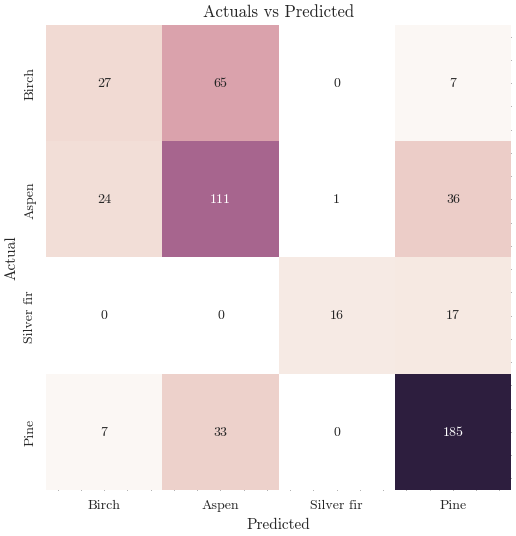

In [13]:
metrics_description(datavector_rf_wf[0]['y test data'], datavector_rf_wf[0]['y predicted'])

In [31]:
rf_class_metrics = get_classes_metrics(datavector_rf_wf)

In [32]:
rf_class_metrics

,iteration,names,f1_scores,precision_list,recall
0,1,Birch,0.47,0.56,0.41
1,1,Aspen,0.67,0.64,0.70
2,1,Silver fir,0.67,0.62,0.73
3,1,Pine,0.74,0.72,0.75


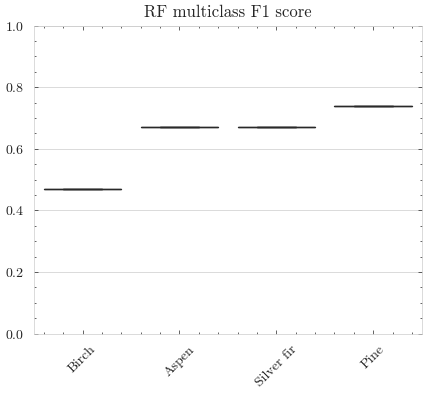

In [33]:
#f1 score plot
plt.figure(figsize=(5,4))
sns.boxplot(x = rf_class_metrics['names'],
            y = rf_class_metrics['f1_scores'], palette=colors)
plt.xlabel('')
plt.ylabel('')
plt.title('RF multiclass F1 score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
#plt.savefig('RF_multiclass_F1_score.png', dpi = 300)
plt.show()

In [15]:
get_metrics_average(datavector_rf_wf)
rf_best_model = get_best_model(datavector_rf_wf)

NameError: name 'datavector_svc_wf' is not defined

In [ ]:
rf_worst_model = get_worst_model(datavector_rf_wf)

### SVC

In [ ]:
# svc random grid

svc_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'poly']
             }

# vector of 5 model iterations to evaluate average performance

datavector_svc_wf = []
for i in range(5):
    svc_model = get_predictions(data_scaled = df_scaled,
                model = SVC(),
                param_grid = svc_grid,
                target_column = 'class', 
                smote_balance=False,
                cv=5, 
                n_iter_search=3)
    datavector_svc_wf.append(svc_model)

In [18]:
datavector_svc_wf[0].keys()

dict_keys(['model', 'X_train data', 'y train data', 'X test data', 'y test data', 'y predicted'])

Accuracy score: 96.66%
Precision score: 96.68%
Recall score: 96.66%
F1-Score: 93.89%
Kappa score: 95.44%


,names,f1_scores,precision_list,recall
0,trees,0.92,0.91,0.93
1,flooded vegetation,0.88,0.86,0.89
2,open water,1.00,1.00,1.00
3,settlements,0.96,0.96,0.96
4,bare soil,0.96,0.95,0.97
5,agriculture,1.00,1.00,1.00
6,shrubs,0.86,0.93,0.79


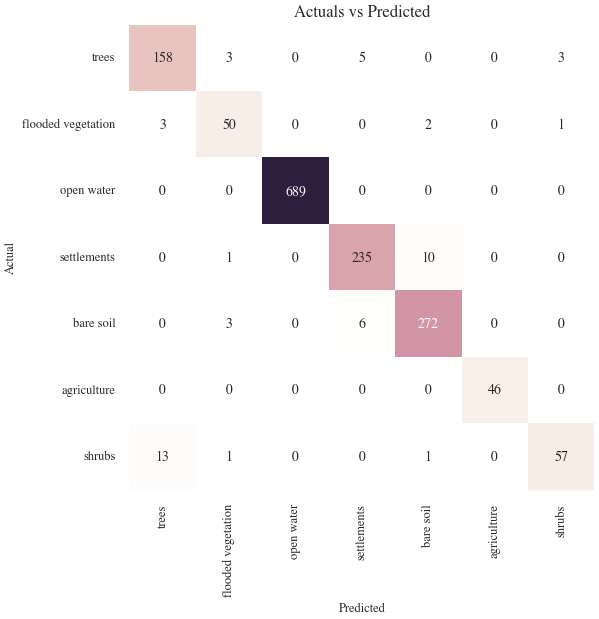

In [19]:
metrics_description(datavector_svc_wf[3]['y test data'], datavector_svc_wf[3]['y predicted'])

In [20]:
svc_class_metrics = get_classes_metrics(datavector_svc_wf)

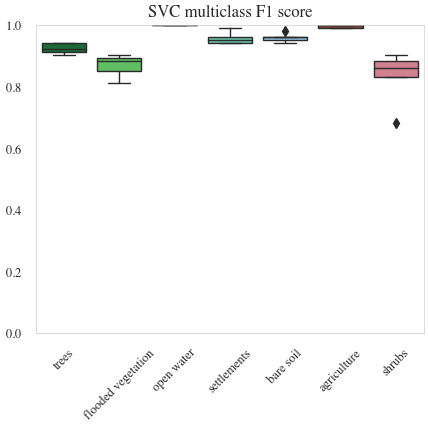

In [21]:
#f1 score plot
plt.figure(figsize=(5,4))
sns.boxplot(x = svc_class_metrics['names'],
            y = svc_class_metrics['f1_scores'], palette=colors)
plt.xlabel('')
plt.ylabel('')
plt.title('SVC multiclass F1 score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
#plt.savefig('SVC_multiclass_F1_score.png', dpi = 300)
plt.show()

In [33]:
display(get_metrics_average(datavector_svc_wf))
svc_best_model = get_best_model(datavector_svc_wf)

,iteration,f1_scores,precision_list,recall
0,1,0.96,0.98,0.98
1,2,0.95,0.97,0.97
2,3,0.90,0.95,0.95
3,4,0.94,0.97,0.97
4,5,0.92,0.96,0.96


In [40]:
svc_worst_model = get_worst_model(datavector_svc_wf)

## kNN

In [27]:
#knn random grid
metric = ['euclidean','manhattan','chebyshev','minkowski']
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 100, num = 50)] 
weights = ['uniform','distance']
random_grid_knn = {
    'n_neighbors': n_neighbors,
    'weights': weights,
    'metric': metric
}

# vector of 5 model iterations to evaluate average performance on non-filtered data
datavector_knn_wf = []

for i in range(5):
    knn_model_wf = get_predictions(data_scaled=df_scaled,
                model = KNeighborsClassifier(),
                param_grid = random_grid_knn,
                target_column = 'id', 
                smote_balance=False,
                cv=5, 
                n_iter_search=3)
    datavector_knn_wf.append(knn_model_wf)

Accuracy score: 94.87%
Precision score: 95.20%
Recall score: 94.87%
F1-Score: 88.82%
Kappa score: 92.99%


,names,f1_scores,precision_list,recall
0,trees,0.90,0.93,0.88
1,flooded vegetation,0.66,0.63,0.68
2,open water,1.00,1.00,1.00
3,settlements,0.94,0.97,0.92
4,bare soil,0.96,0.95,0.96
5,agriculture,0.99,1.00,0.98
6,shrubs,0.77,0.70,0.85


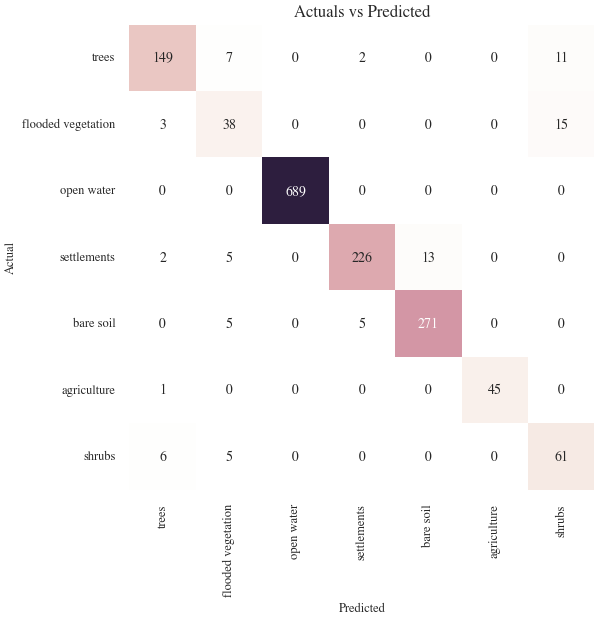

In [28]:
metrics_description(datavector_knn_wf[3]['y test data'], datavector_knn_wf[3]['y predicted'])

In [29]:
knn_class_metrics = get_classes_metrics(datavector_knn_wf)

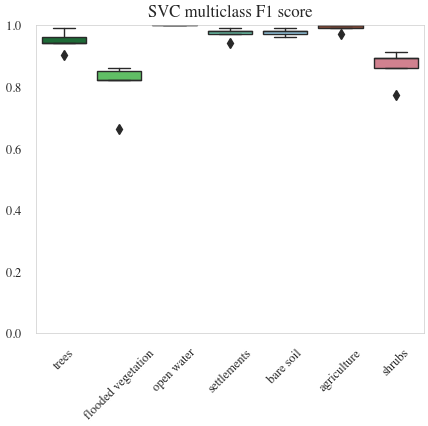

In [30]:
#f1 score plot
plt.figure(figsize=(5,4))
sns.boxplot(x = knn_class_metrics['names'],
            y = knn_class_metrics['f1_scores'], palette=colors)
plt.xlabel('')
plt.ylabel('')
plt.title('SVC multiclass F1 score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
#plt.savefig('SVC_multiclass_F1_score.png', dpi = 300)
plt.show()

In [32]:
display(get_metrics_average(datavector_knn_wf))
knn_best_model = get_best_model(datavector_knn_wf)

,iteration,f1_scores,precision_list,recall
0,1,0.96,0.99,0.99
1,2,0.95,0.98,0.98
2,3,0.95,0.97,0.97
3,4,0.89,0.95,0.95
4,5,0.94,0.98,0.97


In [41]:
knn_worst_model = get_worst_model(datavector_knn_wf)

# Saving models

In [47]:
dump(svc_best_model, 'svc_best_model.joblib')
dump(rf_best_model, 'rf_best_model.joblib')
dump(knn_best_model, 'knn_best_model.joblib')

['knn_best_model.joblib']

In [48]:
dump(svc_worst_model, 'svc_worst_model.joblib')
dump(rf_worst_model, 'rf_worst_model.joblib')
dump(knn_worst_model, 'knn_worst_model.joblib')

['knn_worst_model.joblib']

## Forest mask classification 

In [13]:
def NDVI(red: pd.Series, nir: pd.Series):
    ndvi = (nir - red) / ((nir + red).apply(lambda x: 0.000001 if x == 0 else x))
    return ndvi

def EVI(red: pd.Series, nir: pd.Series):
    evi2 = (
        2.5
        * (nir - red)
        / ((nir + 2.4 * red + 1).apply(lambda x: 0.000001 if x == 0 else x))
    )
    return evi2

def NDRE(red_far: pd.Series, nir: pd.Series):
    ndre = (nir - red_far) / (
        (nir + red_far).apply(lambda x: 0.000001 if x == 0 else x)
    )
    return ndre

def MSAVI(red: pd.Series, nir: pd.Series):
    msavi = (2 * nir + 1 - ((2 * nir + 1) ** 2 - 8 * (nir - red)) ** (1 / 2)) / 2
    return msavi


def FCI(red: pd.Series, nir: pd.Series):
    fci = np.sqrt(red * nir)
    return fci

def normalize_pixel(X: np.ndarray) -> np.ndarray:
        X = X / 10000
        X = np.clip(X, 0, 0.3)
        return X
    
        
def get_SVI(df: pd.DataFrame) -> pd.DataFrame:
    nir = df.loc[:, "B08"]
    red = df.loc[:, "B04"]
    red_far = df.loc[:, "B05"]
    df.loc[:, "NDVI"] = NDVI(red=red, nir=nir)
    df.loc[:, "EVI"] = EVI(red=red, nir=nir)
    df.loc[:, "MSAVI"] = MSAVI(red=red, nir=nir)
    df.loc[:, "NDRE"] = NDRE(red_far=red_far, nir=nir)
    df.loc[:, "FCI"] = FCI(red=red, nir=nir)
    return df


def get_tiles(ds, width=256, height=256):
    nols, nrows = ds.meta['width'], ds.meta['height']
    offsets = product(range(0, nols, width), range(0, nrows, height))
    big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
    for col_off, row_off in  offsets:
        window =windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, ds.transform)
        yield window, transform

def get_dataset(x: np.ndarray)->pd.DataFrame:
    
    
    col_names = ["B01","B02","B03","B04",
            "B05","B06","B07","B08",
            "B8A","B09","B10","B11","B12"]
    texture_columns = [
            "ASM1",
            "ASM2",
            "contrast1",
            "contrast2",
            "correlation1",
            "correlation2",
            "dissimilarity1",
            "dissimilarity2",
            "energy1",
            "energy2",
            "homogeneity1",
            "homogeneity2",
        ]
    bands = x[:13, ...]
    bands = to_2d_array(x[:13, ...])    
    df = pd.DataFrame(bands.T, columns=col_names)
    df[col_names] = normalize_pixel(df.values)
    df = df.drop(columns='B10')
    df = get_SVI(df)
    terrain = to_2d_array(x[16:20, ...])
    df_terrain = pd.DataFrame(terrain.T, columns=["aspect", "slope", 
                                                      "wetnessindex", "sink"])
    mask = df_terrain["wetnessindex"] < 0
    df_terrain.loc[mask, "wetnessindex"] = 0    


    texture = to_2d_array(x[20:32, ...])
    df_texture = pd.DataFrame(texture.T, columns=texture_columns)
    return pd.concat([df,df_terrain, df_texture], axis=1)

def to_2d_array(x: np.ndarray)->np.ndarray:
    return x.reshape(x.shape[0], x.shape[1] * x.shape[2])

def save_tif(raster_input:str, raster_output:str, values:np.array):
    in_data, out_data = None, None
    in_data = gdal.Open(raster_input)
    if in_data is None:
        print ('Unable to open %s' % raster_input)
    band1 = in_data.GetRasterBand(1)
    rows = in_data.RasterYSize
    cols = in_data.RasterXSize
    driver = in_data.GetDriver()
    out_data = driver.Create(raster_output, cols, rows, 1, GDT_Int16)
    dem_data = np.array(values)
    out_band = out_data.GetRasterBand(1)
    out_band.WriteArray(dem_data)
    out_band.FlushCache()
    out_band.SetNoDataValue(-1)

    out_data.SetGeoTransform(in_data.GetGeoTransform())
    out_data.SetProjection(in_data.GetProjection())
    del out_data
    return 'Done'

def save_tif_rasterio(raster_input:str, raster_output:str, values:np.array, nodata: int = 0):
    """
    Save numpy array to geotiff
    """
    with rio.open(raster_input, 'r+') as src: 
        kwargs = src.meta
        kwargs.update(
            dtype=rio.int32,
            count=1,
            compress='lzw',
            nodata=nodata)
    with rio.open(raster_output, 'w', **kwargs) as dst:
        dst.write_band(1, values.astype(rio.int32))
        print(f'Saved geotiff: {raster_output}')
        
        
#for getting model predictions


def get_predictions(data_scaled, 
                    model,
                    param_grid, 
                    target_column,
                    split_rate: float=0.25,
                    smote_balance: bool=True,
                    cv: int=5, 
                    to_drop_columns: list = ['key'],
                    n_iter_search: int=3):

    
    data_scaled = data_scaled.drop(columns = to_drop_columns)
    labels = data_scaled[target_column] #get label data
    indices=np.arange(data_scaled.shape[0]) #get indices numpy
    
    while True:
        train_inds, test_inds = next(GroupShuffleSplit(test_size=test_size, 
                                                   n_splits=2#,random_state = 40
                                                      ).split(data, groups=data['key']))
        #because we need pixels from same plots to be separated in train and test

        train = data.iloc[train_inds]
        test = data.iloc[test_inds]
        if len(train[target_column].unique(
        )) == len(test[target_column].unique(
        )) == len(data[target_column].unique()): #because we need classes to be represented in train and test
            break
            

    #class balansing with smote
    if smote_balance is True:
        smote = SMOTE(random_state = 42)
        X, y = smote.fit_resample(train.loc[:, train.columns!=target_column],
                                  train[target_column]) #drops 3 columns: key, class, and forest
        df_smote = pd.DataFrame(X, columns = train.loc[:, train.columns!=target_column].columns.tolist()) #drops 3 columns: key, class, and forest
        df_smote = df_smote
        #we set train/test from SMOTE results
        X_train = df_smote
        y_train = y
        X_test = test.loc[:, test.columns!=target_column]  
        y_test = test[target_column]
        #we set train/test as it is
    else:
        X_train = train.loc[:, train.columns!=target_column]
        y_train = train[target_column]
        X_test = test.loc[:, test.columns!=target_column] 
        y_test = test[target_column]


    print(X_train.columns)
    #parameters optimisation
    
    gs = RandomizedSearchCV(model, 
                            param_distributions = param_grid,
                            n_iter = n_iter_search, 
                            cv = cv, 
                            scoring= 'f1_weighted')
    gs.fit(X_train, y_train)  
    y_pred = gs.best_estimator_.predict(X_test)
    model_fit = gs.best_estimator_
    
    results = {'model': model_fit,
               'X_train data': X_train,
               'y train data':  y_train,
               'X test data': X_test,
               'y test data': y_test,
               'y predicted': y_pred
        
    }

    return results

In [136]:
df = df_scaled.copy()

df[['forest']] = -999
# 1. Code forest
mask_forest = df['class'] < 10
df.loc[mask_forest, 'forest'] = 1
df.loc[~mask_forest, 'forest'] = 0

## Random Forest - Forest

In [137]:
#for random forest

# Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] # [MG]: кажется можно короче чем np.arange
n_estimators = np.arange(200,500,10)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

max_depth = np.arange(10,110,11)
# max_depth.append(None) # [MG]: а это зачем? 
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
# bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
rf_model = get_predictions(data_scaled = df,
            model = RandomForestClassifier(n_jobs=-1, 
                                           bootstrap=True, 
                                           verbose=0),
            param_grid = random_grid,
            to_drop_columns=['key', 'class'],
            target_column = 'forest', # [MG]: был id, а это что было? 
            smote_balance=False,
            cv=5, 
            n_iter_search=15) # [MG: За что отвечает этот параметр?]
# datavector_rf_wf.append(rf_model)

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09',
       'B11', 'B12', 'NDVI', 'EVI', 'MSAVI', 'NDRE', 'FCI', 'aspect', 'slope',
       'wetnessindex', 'sink', 'ASM1', 'ASM2', 'contrast1', 'contrast2',
       'correlation1', 'correlation2', 'dissimilarity1', 'dissimilarity2',
       'energy1', 'energy2', 'homogeneity1', 'homogeneity2'],
      dtype='object')


In [135]:
# metrics_description(rf_model['y test data'], rf_model['y predicted'])

### SVC - Forest

In [141]:
# svc random grid

svc_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'poly']
             }

# datavector_svc_wf = []
svc_model = get_predictions(data_scaled = df,
             model = SVC(verbose=0),
            param_grid = svc_grid,
            to_drop_columns=['key', 'class'],
            target_column = 'forest', # [MG]: был id, а это что было? 
            smote_balance=False,
            cv=5, 
            n_iter_search=15) # [MG: За что отвечает этот параметр?]
# datavector_svc_wf.append(svc_model)

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09',
       'B11', 'B12', 'NDVI', 'EVI', 'MSAVI', 'NDRE', 'FCI', 'aspect', 'slope',
       'wetnessindex', 'sink', 'ASM1', 'ASM2', 'contrast1', 'contrast2',
       'correlation1', 'correlation2', 'dissimilarity1', 'dissimilarity2',
       'energy1', 'energy2', 'homogeneity1', 'homogeneity2'],
      dtype='object')


## kNN - Forest

In [142]:
#knn random grid
metric = ['euclidean','manhattan','chebyshev','minkowski']
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 100, num = 50)] 
weights = ['uniform','distance']
random_grid_knn = {
    'n_neighbors': n_neighbors,
    'weights': weights,
    'metric': metric
}



knn_model_wf = get_predictions(data_scaled=df,
                model = KNeighborsClassifier(),
                param_grid = random_grid_knn,
                to_drop_columns=['key', 'class'],
                target_column = 'forest', # [MG]: был id, а это что было? 
                smote_balance=False,
                cv=5, 
                n_iter_search=15) # [MG: За что отвечает этот параметр?]

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09',
       'B11', 'B12', 'NDVI', 'EVI', 'MSAVI', 'NDRE', 'FCI', 'aspect', 'slope',
       'wetnessindex', 'sink', 'ASM1', 'ASM2', 'contrast1', 'contrast2',
       'correlation1', 'correlation2', 'dissimilarity1', 'dissimilarity2',
       'energy1', 'energy2', 'homogeneity1', 'homogeneity2'],
      dtype='object')


## GradientBoosting - Forest

In [147]:
gb_grid = {
#     "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8, 12],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10, 50, 100, 200]
    }

gb_model = get_predictions(data_scaled=df,
                model = GradientBoostingClassifier(),
                param_grid = gb_grid,
                to_drop_columns=['key', 'class'],
                target_column = 'forest', # [MG]: был id, а это что было? 
                smote_balance=False,
                cv=5, 
                n_iter_search=15) # [MG: За что отвечает этот параметр?]

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09',
       'B11', 'B12', 'NDVI', 'EVI', 'MSAVI', 'NDRE', 'FCI', 'aspect', 'slope',
       'wetnessindex', 'sink', 'ASM1', 'ASM2', 'contrast1', 'contrast2',
       'correlation1', 'correlation2', 'dissimilarity1', 'dissimilarity2',
       'energy1', 'energy2', 'homogeneity1', 'homogeneity2'],
      dtype='object')


In [148]:
models = {"RandomForest":rf_model['model'],
         "SVC": svc_model['model'],
         "kNN": knn_model_wf['model'],
         "GradientBoosting": gb_model['model']}

In [149]:
import os
import pandas as pd
import numpy as np
import rasterio as rio
from itertools import product
from rasterio import windows
import matplotlib.pyplot as plt


fname = '../rasters/bands_and_terrain_texture.tiff'
def get_forest_mask(raster_input:str,
                    raster_output:str,
                    model, 
                    min_max_scaler: preprocessing.MinMaxScaler):
    with rio.open(raster_input, 'r+') as src:
        meta = src.meta.copy()
        tile_width, tile_height = 512, 512
        output_mask = np.zeros(shape = (meta['height'], meta['width']))
        # Здесь можно добавить tqdm для отслеживания процесса
        for window, transform in get_tiles(src, 
                                           width=tile_width,
                                           height=tile_height):
            meta['transform'] = transform
            meta['width'], meta['height'] = window.width, window.height

            x = src.read(window=window)
            df_original = get_dataset(x)
            forecast=pd.DataFrame(data=np.ones(shape=(len(df_original), 1))*-1,
                                  columns=['forest'])
            mask_nan = df_original.iloc[:, :5].sum(axis=1)==0
            land_df = df_original.loc[~mask_nan]
            land_df.iloc[:, :] = min_max_scaler.transform(land_df.iloc[:, :])
            forest_preds = model.predict(land_df.values)
            forecast.loc[~mask_nan, 'forest'] = forest_preds
            forest_tile = forecast.values.reshape(meta['height'], meta['width'])
            ranges = window.toranges()
            output_mask[ranges[0][0]:ranges[0][1],ranges[1][0]:ranges[1][1]] = forest_tile
            print(window)
    status = save_tif_rasterio(raster_input=raster_input, 
                               raster_output=raster_output,
                               values=output_mask,
                                  nodata=-1)
    print(raster_output)

In [153]:
df.groupby('forest').count()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,...,correlation1,correlation2,dissimilarity1,dissimilarity2,energy1,energy2,homogeneity1,homogeneity2,key,class
forest,,,,,,,,,,,,,,,,,,,,,
0,7250,7250,7250,7250,7250,7250,7250,7250,7250,7250,...,7250,7250,7250,7250,7250,7250,7250,7250,7250,7250
1,1759,1759,1759,1759,1759,1759,1759,1759,1759,1759,...,1759,1759,1759,1759,1759,1759,1759,1759,1759,1759


# 🚨 Добавить балансировку классов, не лесных пикселей очень мало -> цепляет много не леса


## Взять SCALE == 3 !!!!

In [150]:
fname = '../rasters/bands_and_terrain_texture.tiff'
for name, model in models.items():
    output = f'../rasters/predictions_{name}.tif'
    get_forest_mask(raster_input=fname,
                    raster_output=output,
                    model=model,
                    min_max_scaler=min_max_scaler)

Window(col_off=0, row_off=0, width=512, height=512)
Window(col_off=0, row_off=512, width=512, height=512)
Window(col_off=0, row_off=1024, width=512, height=512)
Window(col_off=0, row_off=1536, width=512, height=512)
Window(col_off=0, row_off=2048, width=512, height=512)
Window(col_off=0, row_off=2560, width=512, height=512)
Window(col_off=0, row_off=3072, width=512, height=389)
Window(col_off=512, row_off=0, width=512, height=512)
Window(col_off=512, row_off=512, width=512, height=512)
Window(col_off=512, row_off=1024, width=512, height=512)
Window(col_off=512, row_off=1536, width=512, height=512)
Window(col_off=512, row_off=2048, width=512, height=512)
Window(col_off=512, row_off=2560, width=512, height=512)
Window(col_off=512, row_off=3072, width=512, height=389)
Window(col_off=1024, row_off=0, width=512, height=512)
Window(col_off=1024, row_off=512, width=512, height=512)
Window(col_off=1024, row_off=1024, width=512, height=512)
Window(col_off=1024, row_off=1536, width=512, height=5

Window(col_off=3072, row_off=1024, width=87, height=512)
Window(col_off=3072, row_off=1536, width=87, height=512)
Window(col_off=3072, row_off=2048, width=87, height=512)
Window(col_off=3072, row_off=2560, width=87, height=512)
Window(col_off=3072, row_off=3072, width=87, height=389)
Saved geotiff: ../rasters/predictions_kNN.tif
../rasters/predictions_kNN.tif
Window(col_off=0, row_off=0, width=512, height=512)
Window(col_off=0, row_off=512, width=512, height=512)
Window(col_off=0, row_off=1024, width=512, height=512)
Window(col_off=0, row_off=1536, width=512, height=512)
Window(col_off=0, row_off=2048, width=512, height=512)
Window(col_off=0, row_off=2560, width=512, height=512)
Window(col_off=0, row_off=3072, width=512, height=389)
Window(col_off=512, row_off=0, width=512, height=512)
Window(col_off=512, row_off=512, width=512, height=512)
Window(col_off=512, row_off=1024, width=512, height=512)
Window(col_off=512, row_off=1536, width=512, height=512)
Window(col_off=512, row_off=2048,

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


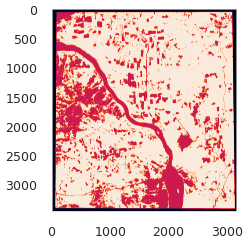

In [127]:
plt.imshow(output_mask)

In [134]:
raster_output = '../rasters/prediction_bratsk_texture.tif'
status = save_tif_rasterio(raster_input=fname, 
                           raster_output=raster_output,
                           values=output_mask,
                          nodata=-1)
print(status)

Saved geotiff: ../rasters/prediction_bratsk_texture.tif
None


findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


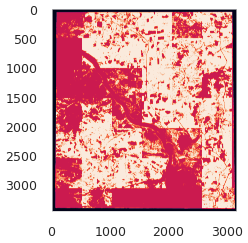

In [117]:
plt.imshow(output_mask)


## Классификация всего растра 

In [ ]:


# Задаем размер кусочков (тайлов), которые будем классифицировать
tile_width, tile_height = 512, 512

# forest_model = load('../models/forest_model_svc.joblib')
forest_type_model = load('../models/forest_type_model_SVC.joblib')
non_forest_model = load('../models/svc_grid_p_nf.joblib')
deciduous_model = keras.models.load_model('../models/cnn_deciduous')
coniferous_model = keras.models.load_model('../models/cnn_coniferous')
scaler = load('../models/forest_scaler.joblib')


dict_coniferous = {0:ForestClasses.Pine.value,
                   1:ForestClasses.Silver_fir.value,
                   -1:-1}
dict_deciduous = {0:ForestClasses.Birch.value,
                   1:ForestClasses.Aspen.value,
                   -1:-1}

with rio.open(fname, 'r+') as src:
    meta = src.meta.copy()
    output_mask = np.zeros(shape = (meta['height'], meta['width']))
    # Здесь можно добавить tqdm для отслеживания процесса
    for window, transform in get_tiles(src, 
                                       width=tile_width,
                                       height=tile_height):
        meta['transform'] = transform
        meta['width'], meta['height'] = window.width, window.height
        
        x = src.read(window=window)
        # get pixels for classification from tiff tile
        df = get_dataset(x)

        # vector to save results
        columns=['forest', 'non_forest','forest_type',
                 'coniferous', 'deciduous']
        forecast=pd.DataFrame(data=np.ones(shape=(len(df), 5))*-1,
                              columns=columns)
        
        mask_nan = df.iloc[:, :5].sum(axis=1)==0
    
        land_df = df.loc[~mask_nan]
        land_df.iloc[:, :] = scaler.transform(land_df.iloc[:, :])
        
        forest_preds = forest_model.predict(land_df.values)
        forecast.loc[~mask_nan, 'forest'] = forest_preds
        # Predict forest type -> 1 - coniferous, 0 - deciduous
        
        mask_forest = forecast['forest'] == 1
        f_type_preds = forest_type_model.predict(land_df.loc[mask_forest])
        forecast.loc[mask_forest, 'forest_type'] = f_type_preds

        non_forest = non_forest_model.predict(land_df.loc[forecast['forest'] == 0])
        forecast.loc[forecast['forest'] == 0,'non_forest'] = non_forest
        
        # Predict deciduous -> Birch - 0, Aspen - 1
        data_for_cnn = land_df.loc[forecast['forest_type']==0].values
        ip_shape = data_for_cnn.shape
        data_for_cnn = data_for_cnn.reshape(-1, ip_shape[1], 1)
        pred_deciduous = (deciduous_model.predict(data_for_cnn)>0.5).astype("int32")
        forecast.loc[forecast['forest_type']==0, 'deciduous'] = pred_deciduous[:,0]
        
        # Predict coniferous -> Pine - 0, Silver fir - 1
        data_for_cnn = land_df.loc[forecast['forest_type']==1].values
        ip_shape = data_for_cnn.shape
        data_for_cnn = data_for_cnn.reshape(-1, ip_shape[1], 1)
        pred_coniferous = (coniferous_model.predict(data_for_cnn)>0.5).astype("int32")
        forecast.loc[forecast['forest_type']==1, 'coniferous'] = pred_coniferous[:,0]
        
        
        forecast['coniferous'] = forecast['coniferous'].apply(lambda x: dict_coniferous[x])
        forecast['deciduous'] = forecast['deciduous'].apply(lambda x: dict_deciduous[x])
        forecast_vector = forecast.max(axis=1)
        forest_tile = forecast_vector.values.reshape(meta['height'], meta['width'])
        ranges = window.toranges()
        output_mask[ranges[0][0]:ranges[0][1],ranges[1][0]:ranges[1][1]] = forest_tile
        print(window)
        # break 
raster_output = '../rasters/prediction_bratsk.tif'
status = save_tif(raster_input=fname, raster_output=raster_output, values=output_mask)
print(status)

## UQ SVM

In [96]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.svm import SVC

# Load a sample dataset (e.g., Iris dataset)
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Create an SVM classifier with probability estimates enabled
svm_classifier = SVC(probability=True)

# Perform cross-validation to estimate uncertainty
# Using cross_val_predict to get predicted probabilities
predicted_probabilities = cross_val_predict(svm_classifier, X, y, cv=5, method='predict_proba')

# Calculate the uncertainty as the standard deviation of the predicted probabilities
uncertainty = np.std(predicted_probabilities, axis=0)

# Alternatively, you can calculate uncertainty as the coefficient of variation
# uncertainty = np.std(predicted_probabilities, axis=0) / np.mean(predicted_probabilities, axis=0)

# Display the uncertainty for each class (assuming a multi-class classification problem)
for class_idx, class_name in enumerate(iris.target_names):
    print(f"Uncertainty for class {class_name}: {uncertainty[class_idx]}")

# You can also calculate the average uncertainty across all classes
average_uncertainty = np.mean(uncertainty)
print(f"Average Uncertainty: {average_uncertainty}")

Uncertainty for class setosa: 0.4480506748704148
Uncertainty for class versicolor: 0.41191238088507565
Uncertainty for class virginica: 0.4183572409025695
Average Uncertainty: 0.4261067655526867


In [98]:
# predicted_probabilities

In [144]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import datasets

X, y = datasets.make_classification(n_samples=100, n_informative=4, n_classes=4)
# X = iris.data
# y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


# Load your trained SVM model
svm_classifier = SVC(kernel='linear', probability=True, decision_function_shape='ovo')
svm_classifier.fit(X_train, y_train)

# Get decision values for your test data
decision_values = svm_classifier.decision_function(X_train, )

# Calculate uncertainty as the absolute distance from the decision boundary
uncertainty = abs(decision_values)

In [145]:
svm_classifier.predict(X_train)

array([0, 3, 0, 1, 1, 1, 0, 3, 1, 0, 1, 2, 2, 1, 2, 3, 1, 0, 1, 0, 1, 0,
       1, 3, 1, 2, 2, 3, 2, 2, 1, 0, 0, 2, 0, 3, 0, 2, 2, 0, 1, 0, 3, 1,
       3, 1, 1, 3, 3, 3, 1, 2, 3, 0, 2, 0, 3, 0, 0, 3, 3, 0, 2, 2, 1, 3,
       1, 0, 0, 1])

In [146]:
y_train

array([0, 3, 0, 1, 1, 1, 1, 3, 1, 1, 1, 2, 2, 1, 2, 3, 1, 0, 1, 0, 1, 0,
       2, 3, 1, 2, 2, 3, 2, 2, 1, 0, 0, 2, 0, 3, 0, 2, 2, 0, 1, 0, 3, 1,
       3, 1, 1, 3, 3, 3, 1, 2, 3, 0, 2, 0, 3, 0, 0, 3, 3, 0, 2, 2, 1, 3,
       2, 0, 0, 2])

$$01 - 02 - 03 - 12 - 13 - 23$$

In [151]:
from scipy import stats


In [155]:
stats.mode([1, 2, 3, 2, 3, 3]) 

ModeResult(mode=3, count=3)

In [154]:
decision_values[1]

array([-0.52332762, -4.2302852 , -4.44249307, -2.01237766, -2.67915304,
       -1.00047603])

In [121]:
uncertainty

array([[2.25077474, 1.29821519, 0.30672904],
       [0.24222078, 2.25870532, 0.85102026],
       [0.2454315 , 2.24893188, 0.9547008 ],
       [0.26380174, 1.19747622, 2.23354565],
       [0.20781899, 2.25428086, 0.79683079],
       [2.24125735, 1.29440468, 0.30352585],
       [0.25807339, 1.22994685, 2.182158  ],
       [0.28742419, 1.15625786, 2.28107265],
       [0.22855696, 2.26025807, 0.80671514],
       [0.24373447, 2.2562946 , 0.8741516 ],
       [0.25078317, 2.25218771, 0.97822444],
       [2.24644332, 1.29475675, 0.30428996],
       [0.27742729, 1.15588273, 2.26776722],
       [2.24200837, 1.29329841, 0.30296414],
       [2.24930505, 1.29358386, 0.30397193],
       [0.27487783, 1.17443671, 2.26094107],
       [0.24742758, 2.24702743, 1.00589073],
       [0.25032727, 2.24602471, 1.05506784],
       [2.22950055, 1.29140824, 0.30052809],
       [2.25308074, 1.29878904, 0.30729776],
       [0.25246191, 2.2478167 , 1.06097819],
       [0.27681745, 1.16961471, 2.26477491],
       [0.

In [108]:
decision_values

array([[ 2.25077474,  1.29821519, -0.30672904],
       [-0.24222078,  2.25870532,  0.85102026],
       [-0.2454315 ,  2.24893188,  0.9547008 ],
       [-0.26380174,  1.19747622,  2.23354565],
       [-0.20781899,  2.25428086,  0.79683079],
       [ 2.24125735,  1.29440468, -0.30352585],
       [-0.25807339,  1.22994685,  2.182158  ],
       [-0.28742419,  1.15625786,  2.28107265],
       [-0.22855696,  2.26025807,  0.80671514],
       [-0.24373447,  2.2562946 ,  0.8741516 ],
       [-0.25078317,  2.25218771,  0.97822444],
       [ 2.24644332,  1.29475675, -0.30428996],
       [-0.27742729,  1.15588273,  2.26776722],
       [ 2.24200837,  1.29329841, -0.30296414],
       [ 2.24930505,  1.29358386, -0.30397193],
       [-0.27487783,  1.17443671,  2.26094107],
       [-0.24742758,  2.24702743,  1.00589073],
       [-0.25032727,  2.24602471,  1.05506784],
       [ 2.22950055,  1.29140824, -0.30052809],
       [ 2.25308074,  1.29878904, -0.30729776],
       [-0.25246191,  2.2478167 ,  1.060

In [109]:
from sklearn.svm import SVC

# Load your trained SVM model with probability estimates enabled
svm_classifier = SVC(probability=True)
svm_classifier.fit(X_train, y_train)

# Get predicted probabilities for your test data
predicted_probabilities = svm_classifier.predict_proba(X_test)

# Calculate uncertainty as the variance or entropy of the predicted probabilities
# You can use np.var(predicted_probabilities, axis=1) for variance
# Or use scipy.stats.entropy(predicted_probabilities, axis=1) for entropy


In [111]:
np.var(predicted_probabilities, axis=1)

array([0.20424622, 0.19027339, 0.17815214, 0.12108496, 0.18948842,
       0.20115049, 0.05188711, 0.21190551, 0.2063262 , 0.17653876,
       0.15639322, 0.20457578, 0.2134102 , 0.20316553, 0.20644368,
       0.21121388, 0.15892992, 0.16523941, 0.18985723, 0.20312024,
       0.12404954, 0.21234437, 0.21306244, 0.20420791, 0.09011822,
       0.19767735, 0.0711609 , 0.21450945, 0.15586933, 0.21335246,
       0.10563549, 0.19659313, 0.11906597, 0.20554688, 0.16248197,
       0.21070394, 0.21526358, 0.11999674, 0.21308402, 0.20418017,
       0.20148357, 0.20154478, 0.20218971, 0.19926904, 0.21251872])

In [110]:
predicted_probabilities

array([[0.97246292, 0.01585704, 0.01168004],
       [0.00943083, 0.9499553 , 0.04061386],
       [0.00843881, 0.92944045, 0.06212074],
       [0.0143102 , 0.16835204, 0.81733776],
       [0.0387941 , 0.94875636, 0.01244954],
       [0.96758086, 0.02103643, 0.01138271],
       [0.01264433, 0.46722822, 0.52012745],
       [0.01406109, 0.00163739, 0.98430152],
       [0.0134286 , 0.97571189, 0.01085952],
       [0.00975959, 0.92672555, 0.06351486],
       [0.00772495, 0.88993217, 0.10234289],
       [0.97297236, 0.01669325, 0.01033438],
       [0.00895431, 0.00440271, 0.98664298],
       [0.97076416, 0.01774101, 0.01149482],
       [0.97589485, 0.01329831, 0.01080684],
       [0.01037059, 0.00635577, 0.98327364],
       [0.00843305, 0.89481321, 0.09675373],
       [0.00743363, 0.90640653, 0.08615984],
       [0.94943515, 0.03527029, 0.01529456],
       [0.97069789, 0.01692451, 0.0123776 ],
       [0.00886079, 0.82285005, 0.16828915],
       [0.00906488, 0.00592283, 0.98501228],
       [0.

In [113]:
!pip3 install mapie

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 KB 1.4 MB/s eta 0:00:00a 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [114]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

from mapie.classification import MapieClassifier
from mapie.metrics import (classification_coverage_score,
                           classification_mean_width_score)

In [115]:


centers = [(0, 3.5), (-2, 0), (2, 0)]
covs = [np.eye(2), np.eye(2)*2, np.diag([5, 1])]
x_min, x_max, y_min, y_max, step = -6, 8, -6, 8, 0.1
n_samples = 1000
n_classes = 3
np.random.seed(42)
X = np.vstack([
    np.random.multivariate_normal(center, cov, n_samples)
    for center, cov in zip(centers, covs)
])
y = np.hstack([np.full(n_samples, i) for i in range(n_classes)])
X_train_cal, X_test, y_train_cal, y_test = train_test_split(
    X, y, test_size=0.2
)
X_train, X_cal, y_train, y_cal = train_test_split(
    X_train_cal, y_train_cal, test_size=0.25
)

xx, yy = np.meshgrid(
    np.arange(x_min, x_max, step), np.arange(x_min, x_max, step)
)
X_test_mesh = np.stack([xx.ravel(), yy.ravel()], axis=1)

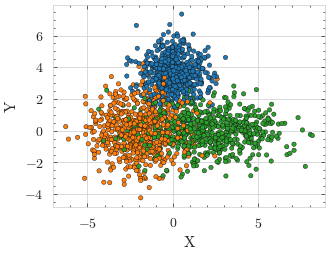

In [116]:
colors = {0: "#1f77b4", 1: "#ff7f0e", 2:  "#2ca02c", 3: "#d62728"}
y_train_col = list(map(colors.get, y_train))
fig = plt.figure()
plt.scatter(
    X_train[:, 0],
    X_train[:, 1],
    color=y_train_col,
    marker='o',
    s=10,
    edgecolor='k'
)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [117]:
clf = GaussianNB().fit(X_train, y_train)
y_pred = clf.predict(X_test)
# y_pred_proba = clf.predict_proba(X_test)
# y_pred_proba_max = np.max(y_pred_proba, axis=1)
mapie_score = MapieClassifier(estimator=clf, cv="prefit", method="score")
mapie_score.fit(X_cal, y_cal)
alpha = [0.2, 0.1, 0.05]
y_pred_score, y_ps_score = mapie_score.predict(X_test_mesh, alpha=alpha)

In [118]:
def plot_scores(n, alphas, scores, quantiles):
    colors = {0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c"}
    plt.figure(figsize=(7, 5))
    plt.hist(scores, bins="auto")
    for i, quantile in enumerate(quantiles):
        plt.vlines(
            x=quantile,
            ymin=0,
            ymax=400,
            color=colors[i],
            ls="dashed",
            label=f"alpha = {alphas[i]}"
        )
    plt.title("Distribution of scores")
    plt.legend()
    plt.xlabel("Scores")
    plt.ylabel("Count")
    plt.show()

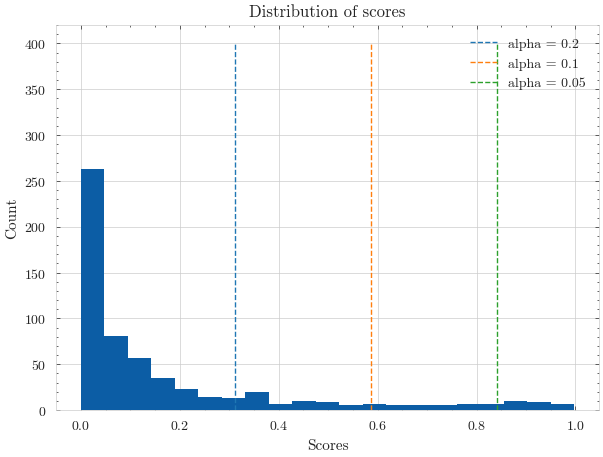

In [119]:
scores = mapie_score.conformity_scores_
n = len(mapie_score.conformity_scores_)
quantiles = mapie_score.quantiles_
plot_scores(n, alpha, scores, quantiles)
